<a href="https://colab.research.google.com/github/Luzinsan/augmentation_and_regularizer/blob/main/Copy_of_Handwritten_Chinese_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import os
import zipfile
import shutil


!git clone https://github.com/AI-FREE-Team/Traditional-Chinese-Handwriting-Dataset.git
OutputFolder = '/content/Handwritten_Data'
!rm -rf '/content/Handwritten_Data'

Cloning into 'Traditional-Chinese-Handwriting-Dataset'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 174 (delta 75), reused 22 (delta 6), pack-reused 18
Receiving objects: 100% (174/174), 77.40 MiB | 25.11 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [32]:
SIZE = 150 # рассматриваем 150 классов

In [33]:
CompressedFiles = []

os.chdir('/content/Traditional-Chinese-Handwriting-Dataset/data')

for item in os.listdir():  
  if item.endswith('.zip'): # Check for ".zip" extension.
    file_path = os.path.abspath(item) # Get full path of the compressed file. 
    CompressedFiles.append(file_path)

for file in CompressedFiles:     
  # Construct a ZipFile object with the filename, and then extract it.
  zip_ref = zipfile.ZipFile(file).extractall(OutputFolder) 
  
  source_path = OutputFolder + '/cleaned_data(50_50)'
  img_list = os.listdir(source_path)

  for img in img_list:
      shutil.move(source_path + '/' + img, OutputFolder) # Move a file to another location. 
  
  shutil.rmtree(OutputFolder + '/cleaned_data(50_50)') 
  #print(f'Decompress successfully {file} ......')
  #print( 'Moving images according to traditional Chinese characters......' )

ImageList = os.listdir(OutputFolder)
ImageList = [img for img in ImageList if len(img)>1]
WordList = list(set([w.split('_')[0] for w in ImageList]))[:SIZE]

for w in WordList:
  try:
    os.chdir(OutputFolder) # Change the current working directory to OutputPath.
    os.mkdir(w) # Create the new word folder in OutputPath.
    MoveList = [img for img in ImageList if w in img]
                
  except: 
    os.chdir(OutputFolder)
    MoveList = [img for img in ImageList if w in img ]
  
  finally:            
    for img in MoveList:
      old_path = OutputFolder + '/' + img
      new_path = OutputFolder + '/' + w + '/' + img
      shutil.move( old_path, new_path )

print( 'Data Deployment completed.' )

Data Deployment completed.


In [34]:
a=0
b=0

for item in os.listdir(OutputFolder):
  if (os.path.isdir(item)):  
    a += 1
    for i in os.listdir(OutputFolder + '/' + item):
      b +=1

#print ('Всего: ' + str(a) + ' слов (папка) / Всего: ' + str(b) + ' образцов')
#print ('В среднем каждое слово содержит: ' + str (b / a) + ' образцов')

In [35]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1)
train_dataset = image_generator.flow_from_directory(str(OutputFolder), class_mode='sparse', batch_size=10, target_size=(50, 50), subset='training')
valid_dataset = image_generator.flow_from_directory(str(OutputFolder), class_mode='sparse', batch_size=10, target_size=(50, 50), subset='validation')

Found 7050 images belonging to 150 classes.
Found 735 images belonging to 150 classes.


In [36]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [37]:
IMG_SIZE = 30

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


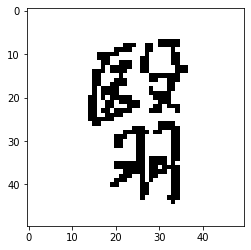

In [38]:
for image_b, label_b in train_dataset:
  #print("Image batch shape: ", image_b.shape)
  #print("Label batch shape: ", label_b.shape)
  plt.imshow(image_b[1])
  image_batch = resize_and_rescale(image_b)
  
  label_batch = label_b
  #print(label_batch)
  break

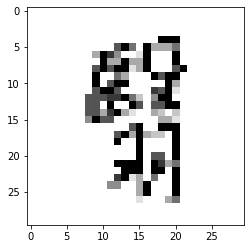

In [39]:
plt.imshow(image_batch[1])

In [40]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=16,  kernel_size=3, activation='relu', padding= 'same' , input_shape=(50,50,3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Conv2D(filters=32,  kernel_size=3, activation='relu', padding= 'same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Conv2D(filters=64,  kernel_size=3, activation='relu', padding= 'same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Conv2D(filters=128,  kernel_size=2, activation='relu', padding= 'same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Conv2D(filters=256,  kernel_size=2, activation='relu', padding= 'same'),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  #tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(SIZE, activation='softmax')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)        

In [41]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(1.8, decay_steps = 705*5, decay_rate = 0.1, staircase = False)

In [42]:
model.compile(
  optimizer=tf.keras.optimizers.Adadelta(lr_schedule),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
EPOCHS = 20
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=EPOCHS)

Epoch 1/20
705/705 [==============================] - 10s 13ms/step - loss: 5.4838 - accuracy: 0.0356 - val_loss: 4.2952 - val_accuracy: 0.0857
Epoch 2/20
705/705 [==============================] - 9s 13ms/step - loss: 2.4000 - accuracy: 0.3989 - val_loss: 1.8732 - val_accuracy: 0.5020
Epoch 3/20
705/705 [==============================] - 9s 13ms/step - loss: 1.0923 - accuracy: 0.7111 - val_loss: 1.0705 - val_accuracy: 0.7510
Epoch 4/20
705/705 [==============================] - 9s 13ms/step - loss: 0.7028 - accuracy: 0.8281 - val_loss: 0.9492 - val_accuracy: 0.7578
Epoch 5/20
705/705 [==============================] - 9s 13ms/step - loss: 0.5069 - accuracy: 0.8774 - val_loss: 0.8544 - val_accuracy: 0.8190
Epoch 6/20
705/705 [==============================] - 9s 13ms/step - loss: 0.3963 - accuracy: 0.9099 - val_loss: 0.7396 - val_accuracy: 0.8463
Epoch 7/20
705/705 [==============================] - 9s 13ms/step - loss: 0.3280 - accuracy: 0.9323 - val_loss: 0.6404 - val_accuracy: 0.861

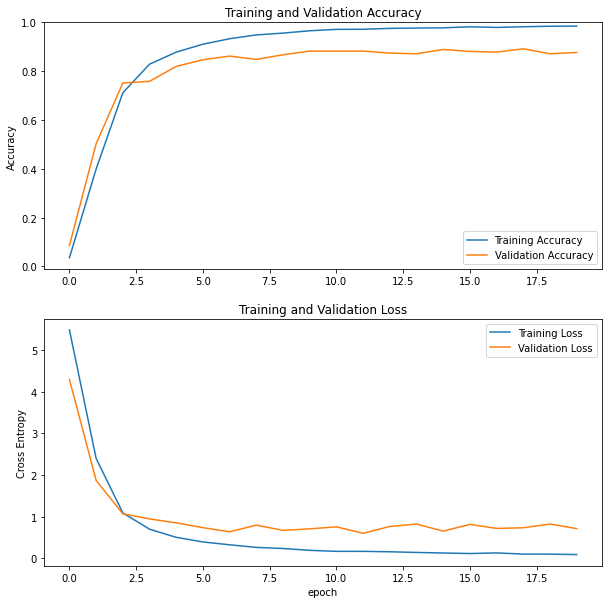

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.5, decay_steps = 705*5, decay_rate = 0.1, staircase = False)

In [48]:
model.compile(
  optimizer=tf.keras.optimizers.Adadelta(lr_schedule),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
EPOCHS = 20
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=EPOCHS)

Epoch 1/20
705/705 [==============================] - 10s 13ms/step - loss: 0.0089 - accuracy: 0.9984 - val_loss: 0.5327 - val_accuracy: 0.9129
Epoch 2/20
705/705 [==============================] - 9s 13ms/step - loss: 0.0077 - accuracy: 0.9989 - val_loss: 0.3917 - val_accuracy: 0.9238
Epoch 3/20
705/705 [==============================] - 9s 13ms/step - loss: 0.0097 - accuracy: 0.9979 - val_loss: 0.4446 - val_accuracy: 0.9116
Epoch 4/20
705/705 [==============================] - 9s 13ms/step - loss: 0.0051 - accuracy: 0.9996 - val_loss: 0.3761 - val_accuracy: 0.9252
Epoch 5/20
705/705 [==============================] - 9s 13ms/step - loss: 0.0077 - accuracy: 0.9987 - val_loss: 0.5076 - val_accuracy: 0.9088
Epoch 6/20
705/705 [==============================] - 9s 13ms/step - loss: 0.0075 - accuracy: 0.9989 - val_loss: 0.3959 - val_accuracy: 0.9211
Epoch 7/20
705/705 [==============================] - 9s 13ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.3751 - val_accuracy: 0.927

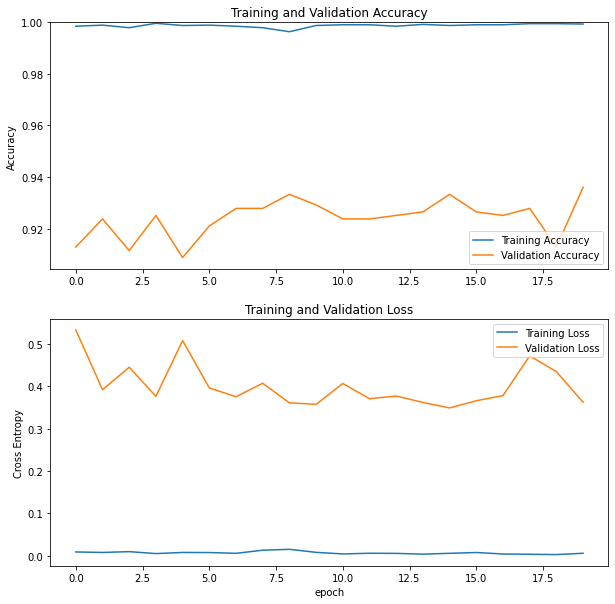

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()